# PLUME VELOCITY

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator
import scipy.io

from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import h5py

# Define the data folder - must i nclude .h5 cas and dat files.
#data_folder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"
#data_folder = r"E:\TR_1.0\\"
#data_folder = r"E:\L5\\"
data_folder = "/Volumes/ThermalAmp/TR1.8_new/"

#from cmcrameri import cm

In [36]:
case_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
case_files = [f for f in case_files if "/._" not in f]

fname = os.path.join(data_folder, case_files[0])

# Read the mesh data from the HDF5 file
with h5py.File(fname, 'r') as f:
    vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
    wallcoords = np.transpose(f['/meshes/1.post/nodes/coords/2'][:])

# Extract NodeX and NodeY
node_x = vertex_list[0]
node_y = vertex_list[1]
WallX = wallcoords[0]
WallY = wallcoords[1]

In [67]:
round(np.mean(WallY), 3)

np.float64(-0.015)

In [7]:
# Define constants
tw = 308
yw = -0.015

# Find *dat.post files
data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]
data_files = [f for f in data_files if "/._" not in f]

def get_time(data_file):
    #return float(data_file.split(".")[0].split("-")[-1])  #My directories
    #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
    return float(data_file.split(".")[1].split("-")[-1])

data_files = sorted(data_files, key=get_time)
print(len(data_files))

# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.015
YMAX    = 0.085
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]


def get_mean_contour(node_x, node_y, mean_SI):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """
    
    from scipy.interpolate import griddata
    SI = griddata((node_x, node_y), mean_SI, (xgrid, ygrid), method='nearest', fill_value=np.nan)
    return SI


def get_T(node_x, node_y, data_file):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """

    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        #U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        #V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]

        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

        
        return flowtime, timestep, T

10000


In [10]:
from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning

# Use LokyBackend tso protect the h5py routine
all_T = Parallel(n_jobs=-1, backend='threading', verbose=1) \
(delayed(get_T) \
 (node_x, node_y, data_file
 ) for data_file in data_files[0:10000])

env: PYTHONWARNINGS=ignore::UserWarning


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 10000 out of

In [13]:

all_T = np.array(all_T, dtype=object)
Ts = all_T[:,2]

T = np.vstack(Ts)

# Check the shape to ensure it is (500, 235616)
print(T.shape)  # Should output (500, 235616)

(10000, 235616)


In [39]:
Ybot.shape

(524,)

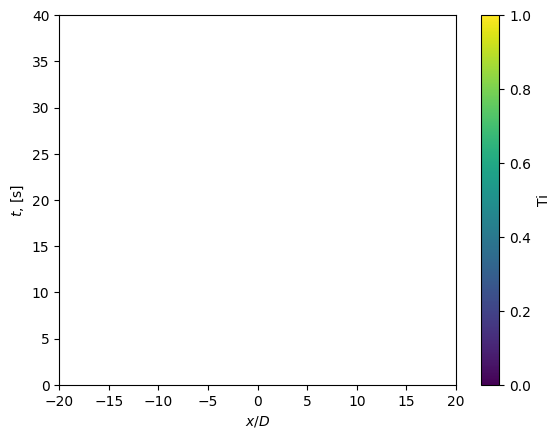

In [100]:
# Check for DataInterpolant existence and create if not present
DataInterpolant = NearestNDInterpolator(np.column_stack((node_x, node_y)), np.arange(len(node_x)))

D = 0.01  
L = (max(WallX) - min(WallX))/D 
Ybot = round(np.mean(WallY/D),3)

FlowTime = all_T[:,0].astype(float) 

# Interpolation grid
x = np.linspace(-L/2, L/2, 512 + 1)
y = Ybot + D/2* np.ones_like(x)

# Get nearest indices
NearestIndices = DataInterpolant(x, y)

# Calculate Ti
Ti = (T[:, NearestIndices.astype(int)] - 298) / (308 - 298)

# Plotting
plt.figure()
plt.imshow(Ti, aspect='auto', extent=[x[0], x[-1], FlowTime[0], FlowTime[-1]], origin='lower')
plt.ylim(0, 40)
plt.colorbar(label='Ti')
plt.xlabel('$x/D$')
plt.ylabel('$t$, [s]')

# Uncomment the following sections as needed to implement additional functionality
# Find local maxima (you may need to adjust this to fit your exact need)
# TF = (Ti[1:] > Ti[:-1]) & (Ti[1:] > Ti[2:])  # Example for local maxima
# TF[:, (np.abs(x) < 2) | (np.abs(x) > 18)] = False

# TimeScale calculations (if applicable)
# TimeScale = np.empty(TF.shape[1])
# for ii in range(TF.shape[1]):
#     t_ = FlowTime[TF[:, ii]]
#     if t_.size > 0:
#         TimeScale[ii] = np.mean(np.diff(t_))  # Using mean instead of trimmean for simplicity

# Find indices for plotting local maxima
# ix, iy = np.where(TF)
# plt.plot(x[iy], FlowTime[ix], '.', color='k', markersize=2)

# Example for plotting temperature evolution
# i_ = np.random.randint(Ti.shape[1])
# plt.figure()
# plt.plot(FlowTime, Ti[:, i_])
# plt.plot(FlowTime[TF[:, i_]], Ti[TF[:, i_], i_], 'ok')

# More plots as needed...
plt.show()

(0.0, 400.0)

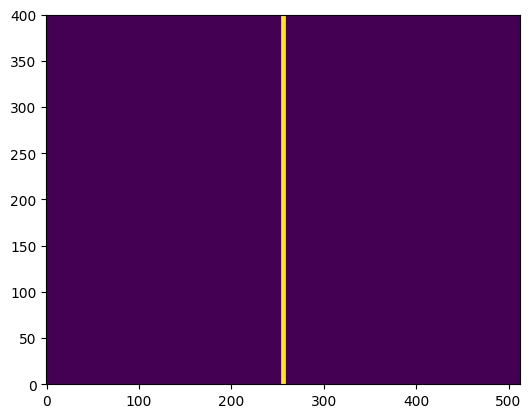

In [101]:
plt.imshow(Ti)
plt.ylim(0,400)

In [82]:
T[:, NearestIndices.astype(int)]

array([[298.6154214 , 298.87431562, 299.17111546, ..., 299.21197418,
        298.9056974 , 298.6372424 ],
       [298.6143048 , 298.87297484, 299.1696133 , ..., 299.21148141,
        298.90523144, 298.63690212],
       [298.61309983, 298.87153166, 299.16799666, ..., 299.21088498,
        298.9047033 , 298.63652744],
       ...,
       [298.66001165, 298.94410603, 299.26542086, ..., 299.18592715,
        298.8850713 , 298.62229417],
       [298.66159465, 298.94618563, 299.26822826, ..., 299.18508385,
        298.88443759, 298.62185454],
       [298.66283044, 298.94780469, 299.27047031, ..., 299.18428114,
        298.88383402, 298.62143513]])

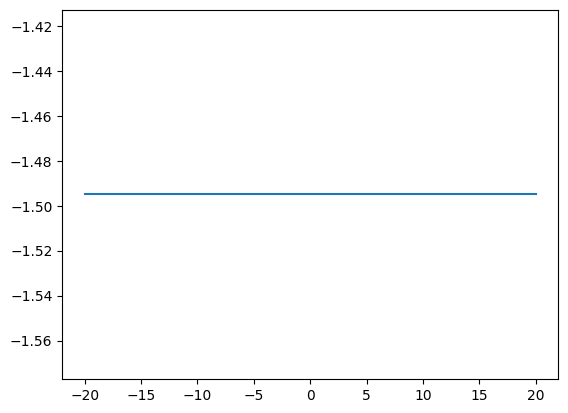

In [102]:
plt.plot(x,y)

In [103]:
y

array([-1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
      

In [64]:
Ybot

np.float64(-1.5)